In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report
from bs4 import BeautifulSoup
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


## Dataset Information

This notebook uses the IMDb movie reviews dataset available [here](https://ai.stanford.edu/~amaas/data/sentiment/). The dataset contains 50,000 movie reviews categorized as positive or negative.

In [ ]:
df_ = pd.read_csv('/content/drive/My Drive/Sentiment Analysis/IMDB Dataset.csv')
df = df_.copy()

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_df(df, head=5):
    print("--------------------- Shape --------------------")
    print(df.shape)
    print("-------------------- Types ---------------------")
    print(df.dtypes)
    print("----------------- NaN Analysis -----------------")
    print(missing_values_analysis(df))
    print("--------------------- Head ---------------------")
    print(df.head())

check_df(df)

--------------------- Shape --------------------
(50000, 2)
-------------------- Types ---------------------
review       object
sentiment    object
dtype: object
----------------- NaN Analysis -----------------
Empty DataFrame
Columns: [Total Missing Values, Ratio]
Index: []
--------------------- Head ---------------------
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


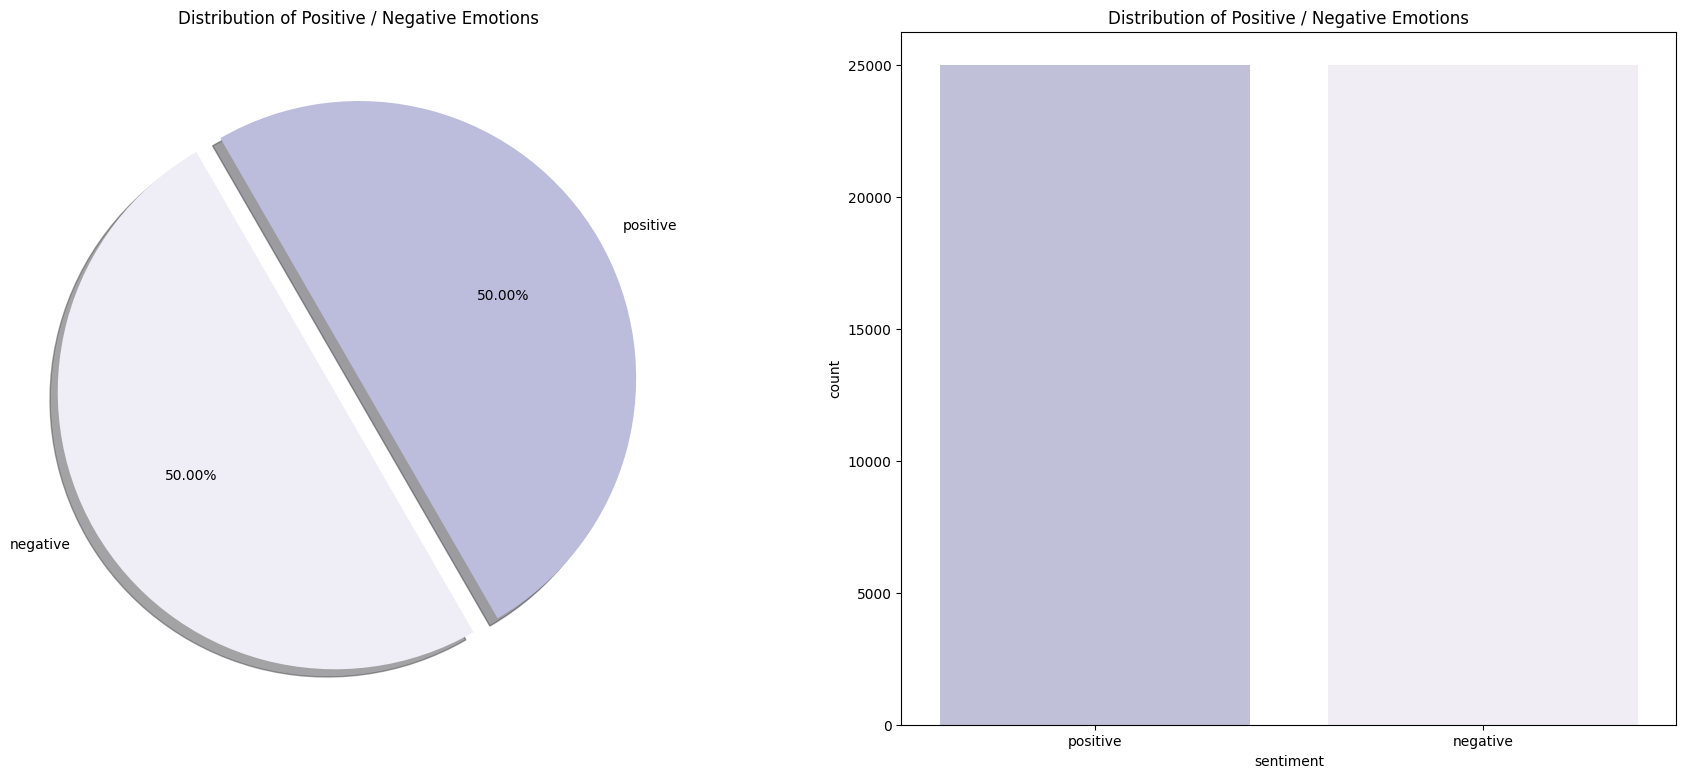

In [ ]:
a, ax = plt.subplots(1, 2, figsize=(22,9))
df['sentiment'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%', ax=ax[0], shadow=True, startangle=300, colors=["#bcbddc", "#efedf5"])
ax[0].set_title('Distribution of Positive / Negative Emotions')
ax[0].set_ylabel('')
sns.countplot(x='sentiment', data = df, ax=ax[1], palette=["#bcbddc", "#efedf5"])
ax[1].set_title('Distribution of Positive / Negative Emotions')
plt.show()

In [ ]:
df.groupby(['sentiment'])[['sentiment']].count()

,sentiment
sentiment,
negative,25000
positive,25000


# Example cleanup on a single review

In [ ]:
example_review = df.review[0]
example_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
example_review = BeautifulSoup(example_review).get_text()
example_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [ ]:
example_review = re.sub("[^a-zA-Z]", ' ', example_review)
example_review

'One of the other reviewers has mentioned that after watching just   Oz episode you ll be hooked  They are right  as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence  which set in right from the word GO  Trust me  this is not a show for the faint hearted or timid  This show pulls no punches with regards to drugs  sex or violence  Its is hardcore  in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary  It focuses mainly on Emerald City  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  Em City is home to many  Aryans  Muslims  gangstas  Latinos  Christians  Italians  Irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [ ]:
example_review = example_review.lower()
example_review

'one of the other reviewers has mentioned that after watching just   oz episode you ll be hooked  they are right  as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence  which set in right from the word go  trust me  this is not a show for the faint hearted or timid  this show pulls no punches with regards to drugs  sex or violence  its is hardcore  in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary  it focuses mainly on emerald city  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  em city is home to many  aryans  muslims  gangstas  latinos  christians  italians  irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wo

In [ ]:
example_review = example_review.split()
example_review

['one',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching',
 'just',
 'oz',
 'episode',
 'you',
 'll',
 'be',
 'hooked',
 'they',
 'are',
 'right',
 'as',
 'this',
 'is',
 'exactly',
 'what',
 'happened',
 'with',
 'me',
 'the',
 'first',
 'thing',
 'that',
 'struck',
 'me',
 'about',
 'oz',
 'was',
 'its',
 'brutality',
 'and',
 'unflinching',
 'scenes',
 'of',
 'violence',
 'which',
 'set',
 'in',
 'right',
 'from',
 'the',
 'word',
 'go',
 'trust',
 'me',
 'this',
 'is',
 'not',
 'a',
 'show',
 'for',
 'the',
 'faint',
 'hearted',
 'or',
 'timid',
 'this',
 'show',
 'pulls',
 'no',
 'punches',
 'with',
 'regards',
 'to',
 'drugs',
 'sex',
 'or',
 'violence',
 'its',
 'is',
 'hardcore',
 'in',
 'the',
 'classic',
 'use',
 'of',
 'the',
 'word',
 'it',
 'is',
 'called',
 'oz',
 'as',
 'that',
 'is',
 'the',
 'nickname',
 'given',
 'to',
 'the',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'it',
 'focuses',
 'mainly',
 'on',
 '

In [ ]:
words = set(stopwords.words("english"))
example_review = [word for word in example_review if word not in words]
example_review

['one',
 'reviewers',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scenes',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pulls',
 'punches',
 'regards',
 'drugs',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word',
 'called',
 'oz',
 'nickname',
 'given',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focuses',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cells',
 'glass',
 'fronts',
 'face',
 'inwards',
 'privacy',
 'high',
 'agenda',
 'em',
 'city',
 'home',
 'many',
 'aryans',
 'muslims',
 'gangstas',
 'latinos',
 'christians',
 'italians',
 'irish',
 'scuffles',
 'death',
 'stares',
 'dodgy',
 'dealings',
 'shady',
 'agreements',
 'never',
 'far',
 'away',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'goes',
 'shows',
 'dare',
 

#Entire dateframe cleanup

In [ ]:
def process(review):
    # Remove HTML tags
    review = BeautifulSoup(review).get_text()
    # Remove punctuation and numbers
    review = re.sub("[^a-zA-Z]", ' ', review)
    # Converting into lowercase and splitting to eliminate stopwords
    review = review.lower()
    review = review.split()
    # Remove stopwords
    swords = set(stopwords.words("english"))
    review = [w for w in review if w not in swords]
    # Combine splitted paragraphs with space
    return(" ".join(review))

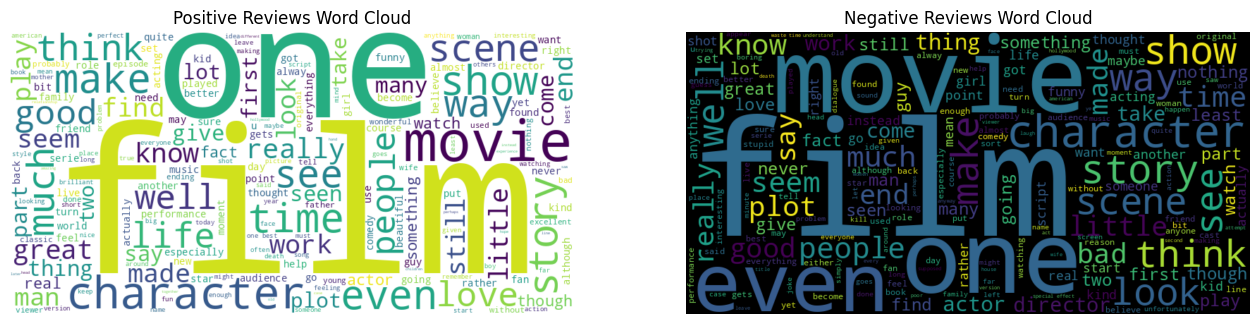

In [ ]:
# Apply the process function to the reviews
df['cleaned_review'] = df['review'].apply(process)

# Separate positive and negative reviews
positive_reviews = df[df['sentiment'] == 'positive']['cleaned_review']
negative_reviews = df[df['sentiment'] == 'negative']['cleaned_review']

# Combine all positive reviews into a single string
positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

# Plot the word clouds
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')

plt.show()

In [ ]:
train_data = []
for i in range(len(df["review"])):
    if (i + 1) % 2500 == 0:
        print("Result = ", i + 1)
    train_data.append(process(df["review"][i]))

Result =  2500
Result =  5000
Result =  7500
Result =  10000
Result =  12500
Result =  15000
Result =  17500
Result =  20000
Result =  22500
Result =  25000
Result =  27500
Result =  30000
Result =  32500
Result =  35000
Result =  37500
Result =  40000
Result =  42500
Result =  45000
Result =  47500
Result =  50000


In [ ]:
train_data

['one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skil

In [ ]:
independent = train_data
dependent = np.array(df["sentiment"])

train_x, test_x, y_train, y_test = train_test_split(independent, dependent, stratify=dependent, test_size=0.2, shuffle=True, random_state=25)

In [ ]:
vectorizer = CountVectorizer(max_features=10000)
train_x = vectorizer.fit_transform(train_x)

In [ ]:
vectorizer

CountVectorizer(max_features=10000)

In [ ]:
train_x

<40000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 3439274 stored elements in Compressed Sparse Row format>

In [ ]:
# Since our machine learning algorithm requires an array for the training process, we convert it to an array.
train_x = train_x.toarray()
train_y = y_train

In [ ]:
print("Total training data :", train_x.shape[0])
print("Total training data :", train_y.shape[0])

Total training data : 40000
Total training data : 40000


In [ ]:
models = []

models.append(('K-Nearest Neighbors', KNeighborsClassifier()))
models.append(('Multinomial Naive Bayes', MultinomialNB()))
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Stochastic Gradient Descent Classifier', SGDClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Random Forest Classifier', RandomForestClassifier()))

In [ ]:
# We convert our test data to vector matrix feature
#This time for our test:
test_result = vectorizer.transform(test_x)

In [ ]:
test_result = test_result.toarray()

In [ ]:
test_result.shape

(10000, 10000)

In [ ]:
for name, model in models:

    %time model.fit(train_x, train_y)
    test_pred = model.predict(test_result)
    print(name, 'Accuracy Score: ', accuracy_score(y_test, test_pred))
    print(name, 'F1 Score: ', f1_score(y_test, test_pred, average='weighted'))
    print(name, 'Precision Score: ', precision_score(y_test, test_pred, average='weighted'))
    print(name, 'Recall Score: ', recall_score(y_test, test_pred, average='weighted'))
    print(name, 'ROC AUC Score: ', roc_auc_score(pd.get_dummies(y_test).values, pd.get_dummies(test_pred).values, average='weighted'))
    print(confusion_matrix(y_test, test_pred))
    print(classification_report(y_test, test_pred))
    print('-----------------------------------------------------------------------')

CPU times: user 41.4 ms, sys: 42 µs, total: 41.4 ms
Wall time: 42.3 ms
K-Nearest Neighbors Accuracy Score:  0.6239
K-Nearest Neighbors F1 Score:  0.622590687840162
K-Nearest Neighbors Precision Score:  0.6256435352354973
K-Nearest Neighbors Recall Score:  0.6239
K-Nearest Neighbors ROC AUC Score:  0.6239
[[3414 1586]
 [2175 2825]]
              precision    recall  f1-score   support

    negative       0.61      0.68      0.64      5000
    positive       0.64      0.56      0.60      5000

    accuracy                           0.62     10000
   macro avg       0.63      0.62      0.62     10000
weighted avg       0.63      0.62      0.62     10000

-----------------------------------------------------------------------
CPU times: user 35.2 s, sys: 53.1 ms, total: 35.2 s
Wall time: 35.5 s
Multinomial Naive Bayes Accuracy Score:  0.8549
Multinomial Naive Bayes F1 Score:  0.854898419843792
Multinomial Naive Bayes Precision Score:  0.8549154601174427
Multinomial Naive Bayes Recall Score